# Two body scattering

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np
import math as m
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre
from scipy.special import sph_harm
from scipy.interpolate import interp1d
from functions import * #Import the functions given in the lecture  
import matplotlib.pyplot as plt

In [21]:
data = np.genfromtxt('wf-obe-lam=800.00.dat', delimiter=';')


Lambda = 800
C0 = 2.470795e-02
hbarc = 197.327
E = -2.225/hbarc
mu =  938.92/hbarc
A = -0.1544435 
m_B = 138/hbarc
q = np.sqrt(-2*mu*E) ###Complex?
p = np.array(data[:,0])
p = np.append(p,q)
p_max = p[-2]
#p_max=100
w = np.array(data[:,1])
w = np.append(w,0)
pot=OBEpot(nx=20,mpi=m_B,C0=C0,A=A,cutoff=Lambda)


In [22]:
def delta(i,j):
    if i==j:
        return 1
    else:
        return 0
def V_matrix(i,j,q):
    #return A/(2*np.pi)*1/((p[i]-p[j])**2+m_B**2)*np.exp(-((p[i]-p[j])**2+m_B**2)/Lambda**2)+C0/(4*np.pi)*np.exp(-(p[i]**2+p[j]**2)/Lambda**2)
    return pot.v(p[i],p[j],0)
    
def A_matrix(i,k,N,p_max,q):
    if k != N:
        return delta(i,k)-2*mu*V_matrix(i,k,q)*p[k]**2*w[k]/(q**2-p[k]**2)
    else:
        return delta(i,k)+np.sum(2*mu*V_matrix(i,N,q)*q**2*w[:-1]/(q**2-p[:-1]**2))-mu*q*V_matrix(i,N,q)*np.log((p_max+q)/(p_max-q))+1j*np.pi*mu*q*V_matrix(i,N,q)
    


def gen_matrices(N,q):
    A_mat = []
    V_mat = []
    for i in range(N):
        A_mat.append([])
        V_mat.append([])
        for j in range(N):
            A_mat[i].append(A_matrix(i,j,N-1,p_max,q))
            V_mat[i].append(V_matrix(i,j,q))
    return A_mat, V_mat

def t_matrix(q):
    A_mat, V_mat = gen_matrices(len(p),q)
    return np.linalg.solve(A_mat, V_mat)

def S_matrix(q):
    return 1-2*1j*np.pi*mu*q*t_matrix(q)[-1][-1]

In [23]:
t_mat = t_matrix(q)
np.abs(S_matrix(1))

0.9999999999999992

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


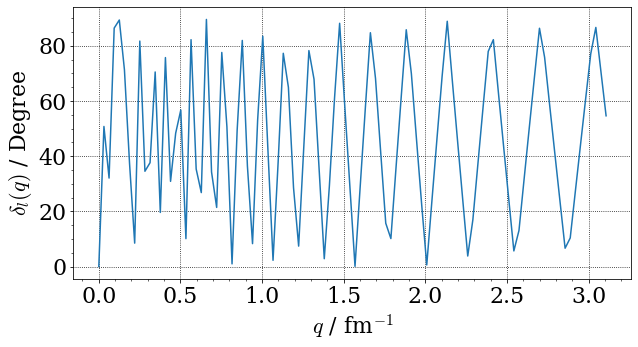

In [26]:
beauty_plot()
#E_list = np.linspace(0,201,500)/hbarc
q_list = np.linspace(0,np.sqrt(200/hbarc*mu*2),100)
phase_shift = []
counter=0
for q in q_list:
    print(counter)
    counter+=1
    phase_shift.append(np.angle(S_matrix(q),deg=True)/2)
plt.plot(q_list,np.abs(np.array(phase_shift)))
plt.xlabel("$q$ / fm$^{-1}$")
plt.ylabel("$\delta_l(q)$ / Degree")
#plt.legend()
plt.show()